In [1]:
from applyllm.accelerators import (
    AcceleratorHelper,
    DIR_MODE_MAP
)
import os

# set up the torch mps environment and huggingface cache home, before importing datasets and transformers
AcceleratorHelper.init_mps_torch(dir_setting=DIR_MODE_MAP.get("mac_local"))

os.environ['XDG_CACHE_HOME']

'/Users/yingding/MODELS'

In [2]:
from transformers import GPT2LMHeadModel

/Users/yingding/VENV/gpt3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## print gpt2 model architecture
w weight for token embedding [50257, 768] - look up table for tokens:
* 50257 tokens in gpt2 vocabulary, 
* 768 dimension embedding for each token - distriburted representation stands in for that token

w weight for positions embedding [1024, 768] - look up table for positions:
* gpt-2 has max token length of 1024 token - 1024 positions each token can be attending to in the past
* 768 parameters as position embedding for each of this position is learned by optimization

```
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
```
are weights and biases of the transformer



In [3]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M parameters
sd_hf = model_hf.state_dict() # raw tensors 

for k, v in sd_hf.items():
    # v is the tensor (values)
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

#### view weight tensor
flatten the tensor weights in Pytorch, flatten it, and slice the last 20 float values.

In [4]:
# sd_hf["transformer.wpe.weight"].view(-1) flatten the tensor from Pytorch to 1D
sd_hf["transformer.wpe.weight"].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

#### Plot the weights values of position embeddings
There are structures in the position embeddings of gpt-2 tokens
* Y axis is the position, each row indicate a position of 1024 in gpt-2 input
* X axis is the representation of the position

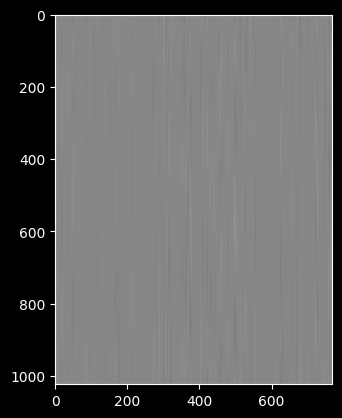

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

#### Plot columns of the position embedding weights
We look at the channel as a function of position from [0, 1023]

The channels are more or less response to the position
* green channel like to fire for every position after 200 till 800
* since the channel position function are noicy/jagged, you can tell this model is not fully trained
* The more trained this model was, the more you would expect channel position function to smooth out
* At the beginning of the optimization, this curves are complete random noise, because the position embedding table is initialized completely at random
* The channel curve of position embedding looks sinusoidal like

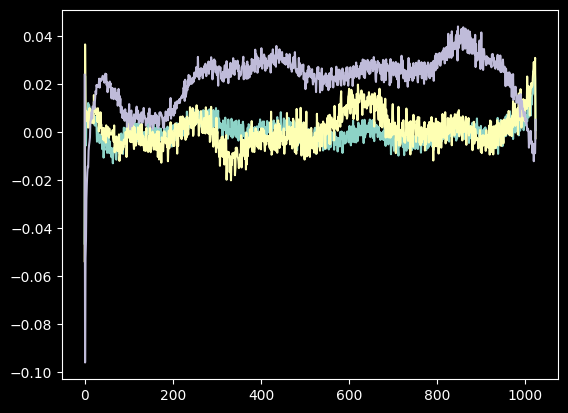

In [6]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

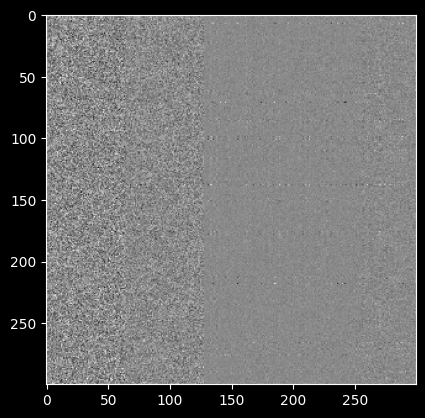

In [7]:
# plot the attention matrix of the first layer with a block of 300x300
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap="gray")
# there is some structure in the attention matrix

# Set seed for transformer to get the generation fixed

With `set_sed(42)`
you shall see the model allways generate the same output:

```console
[{'generated_text': "Hello, I'm a language model, I'm writing a new language for you. But first, I'd like to tell you about the language itself"},
 {'generated_text': "Hello, I'm a language model, and I'm trying to be as expressive as possible. In order to be expressive, it is necessary to know"},
 {'generated_text': "Hello, I'm a language model, so I don't get much of a license anymore, but I'm probably more familiar with other languages on that"},
 {'generated_text': "Hello, I'm a language model, a functional model... It's not me, it's me!\n\nI won't bore you with how"},
 {'generated_text': "Hello, I'm a language model, not an object model.\n\nIn a nutshell, I need to give language model a set of properties that"}]
 ```

In [8]:
# get a pipeline to use the model to sample the text
from transformers import pipeline, set_seed 
generator = pipeline('text-generation', model="gpt2")
# set the seed for reproducibility, if seed is set. the output will be the same
# if the code of weights is the same, with fixed seed, the output will be the same
set_seed(42)
# "Hello..." is prefix, sampling 30 tokens, and return 5 output sequences
# 5 different completions of the prefix
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, I'm writing a new language for you. But first, I'd like to tell you about the language itself"},
 {'generated_text': "Hello, I'm a language model, and I'm trying to be as expressive as possible. In order to be expressive, it is necessary to know"},
 {'generated_text': "Hello, I'm a language model, so I don't get much of a license anymore, but I'm probably more familiar with other languages on that"},
 {'generated_text': "Hello, I'm a language model, a functional model... It's not me, it's me!\n\nI won't bore you with how"},
 {'generated_text': "Hello, I'm a language model, not an object model.\n\nIn a nutshell, I need to give language model a set of properties that"}]